# Section 1: Data Loading & Initial Glance
In this section I load the CSV into a pandas DataFrame. Before doing any transformation, I like to  check: dimensions, column names, sample rows.

In [1]:
# --- Standard Library ---
import re
from string import punctuation
from collections import Counter

# --- Third-Party Core ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk  # Used for potential token utilities / future extensions

# --- Scikit-Learn Core Utilities ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
 )

# Ensure nltk punkt resource is available (safe to ignore if already downloaded)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

import pandas as pd  # pandas: tabular data backbone
import numpy as np    # numpy: numerical support (may use for arrays, metrics)
from sklearn.model_selection import train_test_split  # splitting later (imported now for clarity)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import pandas as pd


In [ ]:

# Reading CSV: encoding set to 'latin-1' to tolerate any extended characters without decode errors.
df = pd.read_csv('combined_emotion.csv', encoding='latin-1')

print('Shape:', df.shape)  # (rows, columns) scale awareness for feature size planning
# Missing values: if any appear in emotion or sentence I'll decide whether to drop or fill with empty string.
print('\nMissing Values per Column:\n', df.isna().sum())
# Duplicate rows can inflate apparent performance if both copies split across train/test.
print('\nDuplicate Rows:', df.duplicated().sum())

# Remove exact duplicate rows early to prevent data leakage inflation.
before_dups = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after_dups = df.shape[0]
removed = before_dups - after_dups
print(f"Duplicates removed: {removed} (from {before_dups} -> {after_dups})")

df.head()

Shape: (422746, 2)

Missing Values per Column:
 sentence    0
emotion     0
dtype: int64

Duplicate Rows: 6623
Duplicates removed: 6623 (from 422746 -> 416123)
Duplicates removed: 6623 (from 422746 -> 416123)


,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear


# Section 2: Class Distribution Visualization


C:\Users\Lukita\AppData\Local\Temp\ipykernel_36656\2090570159.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


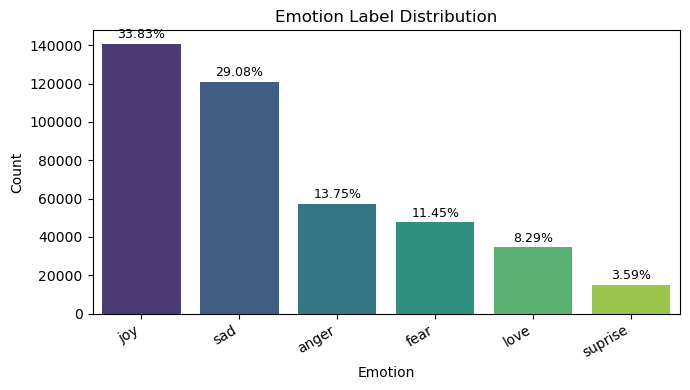

In [ ]:
# Section 2 / Early EDA: Label distribution & basic proportions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from sklearn.preprocessing import LabelEncoder

# Find nltk tokenizer resource
nltk.data.find('tokenizers/punkt')

# Frequency counts sorted gives quick visibility of imbalance risk.
label_counts = df['emotion'].value_counts().sort_values(ascending=False)

# Percentages (rounded) help narrative writing.
label_pct = (label_counts / len(df) * 100).round(2)

plt.figure(figsize=(7,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
for i,(lbl,cnt) in enumerate(label_counts.items()):
    # Annotate each bar with percentage above—compact dual encoding (count height + percent text).
    plt.text(i, cnt + max(label_counts.values)*0.01, f"{label_pct[lbl]}%", ha='center', va='bottom', fontsize=9)
plt.title('Emotion Label Distribution')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Section 3: Text Cleaning Strategy
Now I instantiate a focused cleaning function. I remove obvious formatting noise but keep linguistic surface form. I do not stem or lemmatise because emotional tone may hide in morphological variants ("loving" vs "love" nuance).

Cleaning steps applied:
1. Lowercasing – ensures case-insensitive matching while preserving token boundaries.
2. Remove URLs – usually not emotionally informative; they act like high-variance junk tokens.
3. Remove @mentions & hashtags – social meta markers that rarely encode intrinsic emotion (unless we engineer features explicitly).
4. Remove digits – numeric tokens seldom drive emotion here (if later needed, can reintroduce).
5. Strip punctuation – simplifies token space; retains emotive words unaffected.
6. Collapse repeated whitespace – maintain clean tokenization boundary.

In [18]:
# Section 3 Code: Cleaning implementation
import re
from string import punctuation

def clean_text(t: str):
    # Defensive: ensure string type
    t = str(t).lower()  # Normalise case to reduce sparsity ("Joy" vs "joy").
    t = re.sub(r"https?://\S+", " ", t)          # Strip URLs—they rarely encode emotion themselves.
    t = re.sub(r"@[\w_]+", " ", t)               # Remove @mentions (contextual but not intrinsic emotion).
    t = re.sub(r"#[\w_]+", " ", t)               # Remove hashtags; could alternatively keep text minus '#'.
    t = re.sub(r"\d+", " ", t)                   # Remove digits; reduces noise for numeric IDs etc.
    t = ''.join(ch for ch in t if ch not in punctuation)  # Drop punctuation (keeps emotive tokens clean).
    t = re.sub(r"\s+", " ", t).strip()           # Collapse whitespace: stable token boundaries.
    return t

# Apply transformation and retain both raw + cleaned for auditability.
df['clean_text'] = df['sentence'].astype(str).apply(clean_text)
df.head()  # Peek at cleaned text alongside raw for sanity check.

,sentence,emotion,clean_text
0,i just feel really helpless and heavy hearted,fear,i just feel really helpless and heavy hearted
1,ive enjoyed being able to slouch about relax a...,sad,ive enjoyed being able to slouch about relax a...
2,i gave up my internship with the dmrg and am f...,fear,i gave up my internship with the dmrg and am f...
3,i dont know i feel so lost,sad,i dont know i feel so lost
4,i am a kindergarten teacher and i am thoroughl...,fear,i am a kindergarten teacher and i am thoroughl...


# Section 4: Label Encoding & Train/Test Split
Here I translate emotion strings into numeric IDs using `LabelEncoder`. This is a simple bijection: each unique emotion → integer. I print the mapping so any future confusion matrix or per-class metrics can be interpreted.

I stratified split the dataset. Stratification preserves approximate distribution proportions across train and test subsets.

Design considerations:
- Test size = 25% provides a reasonable evaluation hold-out while keeping enough data for model parameter estimation.
- `random_state=42`: deterministic reproducibility (common scholarly practice; I note it explicitly).

In [19]:
# Section 4 Code: Label encoding + stratified split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['emotion_id'] = le.fit_transform(df['emotion'])  # Bijective mapping stored in encoder
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Label Mapping (emotion -> id):', label_mapping)  # Explicit for reproducibility in report appendices

# Choose cleaned text if available; fallback ensures robustness if earlier cell skipped accidentally.
text_col = 'clean_text'
X = df[text_col]            # Features: raw text strings to be vectorised later
y = df['emotion_id']        # Target: numeric classes

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y  # Stratify preserves class distribution proportions.
 )
print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])

Label Mapping (emotion -> id): {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sad': 4, 'suprise': 5}
Train size: 312092 Test size: 104031


# Section 5A: CountVectorizer + Multinomial Naive Bayes
This section establishes a *foundational* reference model using a unigram Bag‑of‑Words (CountVectorizer) feeding a Multinomial Naive Bayes (MNB) classifier.

Chosen settings:
- `max_features=3000`: Retain the most frequent tokens only—dampens noise from very rare words while keeping core emotional vocabulary.
- `ngram_range=(1,1)`: Unigrams only (deliberately minimal). We postpone bigrams to the enhanced model for a clean ablation.
- `alpha=0.3`: Slightly lighter smoothing than the default 1.0 to reduce probability flattening; empirically often gives a mild lift when vocabulary is pruned.

In [20]:
# Section 5 Code: CountVectorizer + MultinomialNB (Count Model)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report

baseline_clf = Pipeline([
    ('vect', CountVectorizer(max_features=3000, ngram_range=(1,1))),  # Unigram frequency counts (pruned vocab).
    ('clf', MultinomialNB(alpha=0.3))                                 # Light smoothing to avoid over-flattening probabilities.
])

baseline_clf.fit(X_train, y_train)
base_preds = baseline_clf.predict(X_test)

base_acc = accuracy_score(y_test, base_preds)
base_f1 = f1_score(y_test, base_preds, average='weighted')

print('CountVector NB Classification Report (alpha=0.3):')
print(classification_report(y_test, base_preds, target_names=le.classes_))

CountVector NB Classification Report (alpha=0.3):
              precision    recall  f1-score   support

       anger       0.90      0.88      0.89     14309
        fear       0.86      0.84      0.85     11916
         joy       0.91      0.92      0.91     35195
        love       0.79      0.77      0.78      8624
         sad       0.92      0.93      0.93     30247
     suprise       0.76      0.74      0.75      3740

    accuracy                           0.89    104031
   macro avg       0.86      0.85      0.85    104031
weighted avg       0.89      0.89      0.89    104031



# Section 5B: TfidfVectorizer + Multinomial Naive Bayes
This section upgrades the representation from raw occurrence counts to Term Frequency–Inverse Document Frequency (TF-IDF) with both unigrams and bigrams. TF-IDF re-weights tokens to emphasise discriminative terms while down-weighting those that appear in many documents (low information gain). Adding bigrams captures short compositional patterns (negations, intensifiers, multi-word emotion cues).

Parameter choices:
- max_features=12,000: Expanded vocabulary ceiling to accommodate the larger (1,2)-gram space without exploding sparsity. Empirically balances coverage and overfitting risk.
- ngram_range=(1,2): Unigrams retain baseline lexical signal; bigrams inject shallow compositional semantics.
- alpha=0.3 (MNB): Kept identical to the count model to isolate the effect of the representation shift; avoids over-smoothing rare but informative bigrams.

In [ ]:
# Section 5B Code: TF-IDF (uni+bi) + MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report

clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=12000, ngram_range=(1,2))),  # Wider vocab to accommodate added bigram dimension.
    ('clf', MultinomialNB(alpha=0.3))                                    # Keep alpha constant vs baseline to isolate feature effect.
])

clf.fit(X_train, y_train)
impr_preds = clf.predict(X_test)
impr_acc = accuracy_score(y_test, impr_preds)
impr_f1 = f1_score(y_test, impr_preds, average='weighted')

print('Model Classification Report (TF-IDF uni+bi, alpha=0.3):')
print(classification_report(y_test, impr_preds, target_names=le.classes_))

Model Classification Report (TF-IDF uni+bi, alpha=0.3):
              precision    recall  f1-score   support

       anger       0.93      0.79      0.85     14309
        fear       0.88      0.75      0.81     11916
         joy       0.80      0.96      0.88     35195
        love       0.89      0.51      0.64      8624
         sad       0.87      0.94      0.90     30247
     suprise       0.84      0.41      0.55      3740

    accuracy                           0.85    104031
   macro avg       0.87      0.73      0.77    104031
weighted avg       0.86      0.85      0.84    104031



### Section 6A: Linear SVM with Count Vectorizer
Before leveraging TF‑IDF weighting, it is informative to test a margin-based classifier on the raw occurrence space. The CountVectorizer (unigram) retains direct term frequency signals without normalising by document frequency. A linear SVM (hinge loss) often excels in sparse high-dimensional text spaces due to its capacity to find a large-margin separating hyperplane.

Parameter choices:
- Vocabulary cap: 3,000 most frequent unigrams – balances expressiveness with overfitting/latency risk.
- ngram_range=(1,1): Restricts to unigrams to isolate effect of the classifier from higher-order feature expansion.
- C=0.5: Slightly stronger regularisation than default (C=1.0) to mitigate overfitting given moderate feature size.


In [ ]:
# Section 6 (Variant A) Code: Linear SVM with Count Vectorizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

svm_count_clf = Pipeline([
    ('count', CountVectorizer(max_features=3000, ngram_range=(1,1))),
    ('svm', LinearSVC(C=0.5, random_state=42))
])

svm_count_clf.fit(X_train, y_train)
svm_count_preds = svm_count_clf.predict(X_test)
svm_count_acc = accuracy_score(y_test, svm_count_preds)
svm_count_f1 = f1_score(y_test, svm_count_preds, average='weighted')

print('SVM (Count Vectorizer) Classification Report:')
print(classification_report(y_test, svm_count_preds, target_names=le.classes_))

SVM (Count Vectorizer) Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.90      0.91     14309
        fear       0.85      0.85      0.85     11916
         joy       0.92      0.93      0.92     35195
        love       0.81      0.78      0.79      8624
         sad       0.94      0.94      0.94     30247
     suprise       0.73      0.74      0.74      3740

    accuracy                           0.90    104031
   macro avg       0.86      0.86      0.86    104031
weighted avg       0.90      0.90      0.90    104031



### Section 6B: Linear SVM with TF‑IDF
Extends the margin-based approach by incorporating TF‑IDF weighting and bi-grams. TF‑IDF down-weights ubiquitous words (stop-like or dataset-generic tokens) while bi-grams capture short compositional patterns (e.g., negations, intensifiers).

Parameter choices:
- max_features=12,000: Larger lexicon to accommodate expanded n-gram space without exploding dimensionality.
- ngram_range=(1,2): Captures both unigram and bigram signals; bigrams often encode affective phrase structures ("so happy", "not good").
- C=0.3: Slightly stronger regularisation than the Count variant (C=0.5 reduced further) because feature space is richer; mitigates overfitting on sparse high-order terms.

In [ ]:
# Section 6 (Variant B) Code: Linear SVM with TF-IDF
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline

svm_clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=12000, ngram_range=(1,2))),
    ('svm', LinearSVC(C=0.3, random_state=42))
 ])

svm_clf.fit(X_train, y_train)
svm_preds = svm_clf.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)
svm_f1 = f1_score(y_test, svm_preds, average='weighted')

print('SVM (TF-IDF) Classification Report (probabilities approximated):')
print(classification_report(y_test, svm_preds, target_names=le.classes_))

SVM (TF-IDF) Classification Report (probabilities approximated):
              precision    recall  f1-score   support

       anger       0.91      0.90      0.91     14309
        fear       0.85      0.85      0.85     11916
         joy       0.92      0.93      0.92     35195
        love       0.79      0.75      0.77      8624
         sad       0.95      0.95      0.95     30247
     suprise       0.73      0.70      0.72      3740

    accuracy                           0.90    104031
   macro avg       0.86      0.85      0.85    104031
weighted avg       0.90      0.90      0.90    104031



# Section 7: Unified Multi-Metric Evaluation & ROC Analysis
This analytical block consolidates performance comparison across all trained models:
- CountVector NB (Counts)
- Enhanced MNB (TF‑IDF)
- Linear SVM (Count)
- Linear SVM (TF‑IDF)

.
Metrics reported:
1. Accuracy – overall proportion correct (can be biased under imbalance).
2. Weighted F1 – harmonic mean of precision/recall weighted by class support.
3. Macro AUC – treats each class equally; robust for imbalance fairness.
4. Micro AUC – pools decisions across all one-vs-rest tasks; influenced by larger classes.



Consolidated Metrics (higher is better for all columns):
    model  accuracy  weighted_f1  macro_auc  micro_auc
SVM_Count  0.900760     0.900579   0.991138   0.992511
SVM_TFIDF  0.900558     0.899994   0.993342   0.994531
MNB_Count  0.890369     0.889951   0.986579   0.988520
MNB_TFIDF  0.850679     0.842450   0.985330   0.982576


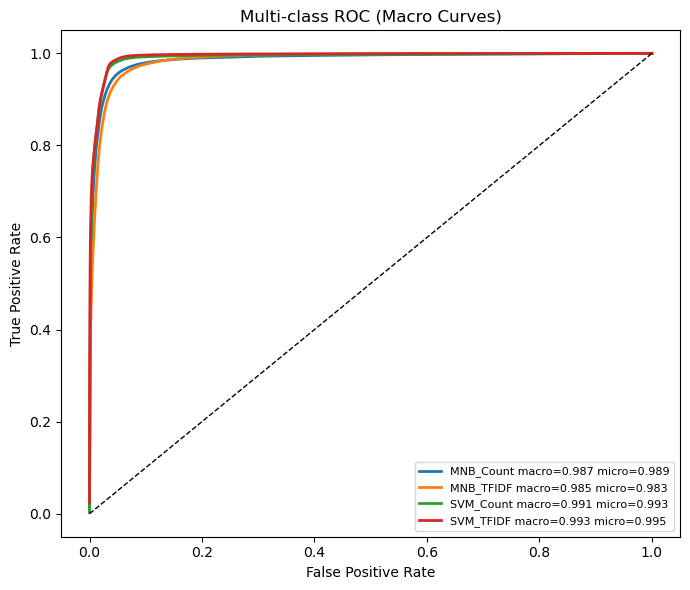

In [ ]:
# Section 8 Code: Unified multi-metric evaluation + ROC plotting

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_prob_matrix(clf, X):

    if hasattr(clf, 'predict_proba'):
        try:
            return clf.predict_proba(X)  # shape = (n_samples, n_classes)
        except Exception as e:
            print(f"Warning: predict_proba failed for {clf}. Falling back to decision_function. Error: {e}")
    if hasattr(clf, 'decision_function'):
        scores = clf.decision_function(X)  # shape: (n_samples,) or (n_samples, n_classes)
        if scores.ndim == 1:  # Binary classification margin vector
            probs_pos = 1.0 / (1.0 + np.exp(-scores))  # sigmoid
            return np.vstack([1 - probs_pos, probs_pos]).T  # shape (n_samples, 2)
        # Multi-class: apply numerically stable softmax
        shifted = scores - scores.max(axis=1, keepdims=True)
        exp_scores = np.exp(shifted)
        softmax = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        return softmax
    raise ValueError(f"Model {clf} has neither predict_proba nor decision_function.")

# classes: sorted unique class labels (integers)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)  # shape: (n_samples, n_classes); 1-of-K encoding

model_probs = {}   # dict: model name -> probability matrix
models_order = []  # preserves insertion order for consistent plotting & table rows

def add_probs(name, clf):
    """Compute & store probability-like outputs for a model, aligning class order if needed."""
    probs = get_prob_matrix(clf, X_test)  # shape (n_samples, n_classes_candidate)
    # Some estimators might internally store classes_ in a different order; enforce global ordering.
    if hasattr(clf, 'classes_'):
        clf_classes = clf.classes_
        if not np.array_equal(clf_classes, classes):
            # Map global class sequence to indices from the classifier's classes_
            reorder_idx = [np.where(clf_classes == c)[0][0] for c in classes]
            probs = probs[:, reorder_idx]
    model_probs[name] = probs
    models_order.append(name)

# Collect probability matrices for each configured model
add_probs('MNB_Count', baseline_clf)
add_probs('MNB_TFIDF', clf)
add_probs('SVM_Count', svm_count_clf)
add_probs('SVM_TFIDF', svm_clf)

# Compute macro & micro ROC AUC per model
macro_auc_map = {}  # model -> macro AUC
micro_auc_map = {}  # model -> micro AUC
for name in models_order:
    probs = model_probs[name]  # shape (n_samples, n_classes)
    # roc_auc_score expects the one-vs-rest matrix for multi_class='ovr'
    macro_auc_map[name] = roc_auc_score(y_test_bin, probs, average='macro', multi_class='ovr')
    micro_auc_map[name] = roc_auc_score(y_test_bin, probs, average='micro', multi_class='ovr')

# Accuracy & Weighted F1 were computed earlier right after each model's prediction step.
# We centralize them here using consistent keys for tabulation.
acc_map = {
    'MNB_Count': base_acc,
    'MNB_TFIDF': impr_acc,
    'SVM_TFIDF': svm_acc,
    'SVM_Count': svm_count_acc
}
wf1_map = {
    'MNB_Count': base_f1,
    'MNB_TFIDF': impr_f1,
    'SVM_TFIDF': svm_f1,
    'SVM_Count': svm_count_f1
}

# Build a consolidated metrics table
summary_rows = []
for m in models_order:
    summary_rows.append({
        'model': m,
        'accuracy': acc_map.get(m, np.nan),
        'weighted_f1': wf1_map.get(m, np.nan),
        'macro_auc': macro_auc_map[m],
        'micro_auc': micro_auc_map[m]
    })
metrics_df = pd.DataFrame(summary_rows).sort_values(by='weighted_f1', ascending=False)

print('\nConsolidated Metrics (higher is better for all columns):')
print(metrics_df.to_string(index=False))

# Plotting: For each model produce a macro ROC curve:
plt.figure(figsize=(7,6))
for name in models_order:
    probs = model_probs[name]  # (n_samples, n_classes)
    # Micro ROC: treat every element in the indicator matrix equally -> flatten arrays.
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), probs.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)

    # Macro ROC: aggregate per-class ROC using interpolation over a merged set of FPR points.
    fprs = []  # list of per-class FPR arrays
    tprs = []  # list of per-class TPR arrays
    for i in range(probs.shape[1]):
        fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], probs[:, i])
        fprs.append(fpr_i)
        tprs.append(tpr_i)
    all_fpr = np.unique(np.concatenate(fprs))  # union of all FPR coordinates
    mean_tpr = np.zeros_like(all_fpr)
    for fpr_i, tpr_i in zip(fprs, tprs):
        # Interpolate each class TPR onto the unified FPR grid then accumulate
        mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)
    mean_tpr /= len(tprs)  # average across classes -> macro TPR curve
    auc_macro = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, lw=2, label=f"{name} macro={auc_macro:.3f} micro={auc_micro:.3f}")

# Chance diagonal for orientation (random classifier)
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC (Macro Curves)')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()